In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/envs/fred_workenv/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41059 instead
  warnings.warn(
/tmp/ipykernel_3208250/2886357020.py:23: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


#### Reconstruct - I. Input save variables

In [2]:
############################################################################################################################################
# PCA_dict: Processed EOF objects; A_dict: Variable anomaly matrices; Af_dict: Flattened variable anomaly matrices
# *note that following EOF conventions, we derived EOFs with anomalies.
############################################################################################################################################
# Basic settings
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/'
expname = ['ctl','ncrf_36h','ncrf_60h','lwcrf']
varname = ['u','v','w']
nummem = [54,26,50,5,75,12,10]
#################################################################################
# 24-hr smoothing model
PCAdict = read_and_proc.depickle(folderpath+'PCA/ctl_PCA_dict1')
# Read files
flatvar = [read_and_proc.depickle(folderpath+'preproc/'+str(expname[i])+'_'+'smooth_preproc_dict1b_g') for i in range(len(expname))]
vardicts = maria_IO.input_output(PCAdict,folderpath,varname,nummem).readvar_separate(listdict=flatvar,varname=['u','v','w','qv','theta','hdia','rad'])
del flatvar#,thetavar
gc.collect()
#################################################################################
#duvwsen_dict = preproc_data('/scratch/08350/tg876493/ruppert2020/output/',['du','dv','dw']).senfile('/ctrlbase/','_CORR',True)

235

#### ForwardFeatureSelector

In [3]:
from sklearn.feature_selection import SelectorMixin
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.model_selection import cross_val_score
import numpy as np
import gc
import importlib
importlib.reload(proc_mlrfcst)
importlib.reload(mlr)

class forwardfeatureadder(BaseEstimator,SelectorMixin,MetaEstimatorMixin):
    """Transformer to add feature at a sequential order
    Parameters:
    estimator: Regression model
    n_features_to_select: number of features to add to the model
    cv: how many folds would we want during cross-validation
    n_jobs: Parallelization
    startfeatures: Features we would like to include in the model without cross-validation [we do this to accentuate the role of heating]
    
    Output:
    self instance
    """
    def __init__(self,estimator,n_features_to_select=None,cv=5,n_jobs=None,startfeatures=None,PCAdict=None,Afdict=None,numcomp=None,LT=None,optigoal='surface',Xsurf=None,Ysurf=None):
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.cv = cv
        self.n_jobs = n_jobs
        self.startfeatures = startfeatures
        self.PCAdict = PCAdict
        self.Afdict = Afdict
        self.numcomp = numcomp
        self.LT = LT
        self.optigoal = optigoal
        self.Xsurf=Xsurf
        self.Ysurf=Ysurf
    
    def get_real_winds(self):
        temp1,temp2,temp3,temp4 = proc_mlrfcst.retrieve_cartesian(PCA_dict=self.PCAdict,Af_dict=self.Afdict,numcomp=self.numcomp,LT=self.LT,
                            forecastPC=None).windrates_real(LT=self.LT)
        return temp1,temp2,temp3,temp4
    
    def convert_forecast_winds(self,yforecast=None):
        try:
            temp1,temp2,temp3,temp4 = proc_mlrfcst.retrieve_cartesian(PCA_dict=self.PCAdict,Af_dict=self.Afdict,numcomp=self.numcomp,LT=self.LT,
                                                                      forecastPC=yforecast).output_reshapeRECON(forecast_eig=yforecast[int(self.LT[i]-1)])
            return temp1,temp2,temp3,temp4
        except:
            temp1,temp2 = proc_mlrfcst.retrieve_cartesian(PCA_dict=self.PCAdict,Af_dict=self.Afdict,numcomp=self.numcomp,LT=self.LT,
                                                                      forecastPC=yforecast,target='surface').output_reshapeRECON(forecast_eig=yforecast)        
            return temp1,temp2
    
    def fit(self, X,y=None):
        """Learn features to select from X.
        X (n_samples,n_features): Training vectors
        Y (n_samples): Target values
        """
        # Define basic settings
        n_features = X.shape[1]
        current_mask = np.zeros(shape=n_features,dtype=bool)
        for index in self.startfeatures:
            current_mask[index] = True
        n_iteractions = self.n_features_to_select
        
        # Do forward selection
        addinput,r2 = [],[]
        clone_estimator = clone(self.estimator)
        for _ in range(n_iteractions):
            #new_feature_idx,r2t = self.get_best_new_feature_R2based(clone_estimator,X,y,current_mask)
            new_feature_idx = self.get_best_new_feature(clone_estimator,X,y,current_mask)
            #r2.append(r2t)
            current_mask[new_feature_idx] = True
            addinput.append(current_mask)
        
        self.support_ = current_mask
        self.new_feature = new_feature_idx
        self.r2 = r2
        return self
    
    def get_best_new_feature(self,estimator,X,y,current_mask):
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores={}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            
            # Add a new feature
            X_new = X[:,candidate_mask]
            # Improvement
            scores[feature_idx] = cross_val_score(estimator,X_new,y,cv=self.cv,scoring=None,n_jobs=self.n_jobs).mean()
        return max(scores,key=lambda feature_idx: scores[feature_idx])
    
    #--------------------------------------------------------------
    # To do -> Add featureselector based on r2
    # Candidate mask -> Xnew
    # fit linear model with (Xnew,y)
    # {output r2 term [time consideration => target: surface u/v]}...repeat for all u/v/w/theta members
    # get component index that results in best r2 score
    # --------[[Exit loops when r2 reaches 0.75?]]-----------------
    # add to mask during fitting 
    #---------------------------------------------------------------------------------------------------
    def get_best_new_feature_R2based(self,estimator,X,y,current_mask):             
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores={}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            # Add a new feature
            X_new = X[:,candidate_mask]
            # Improvement
            LDTME = np.linspace(0,44,45)+1
            y_forecast = mlr.model_fitpredict(X_new,y,estimator,LDTME).modelfit(singleLT=True)[0].predict(X_new)
            #################################################################################################################################################################################################################
            # Forecast winds
            #################################################################################################################################################################################################################
            if self.optigoal=='surface':
                teMP1,teMP2 = self.convert_forecast_winds(y_forecast)
                teMP1s,teMP2s = (teMP1.reshape(teMP1.shape[0],39,360,167)[:,0,:,:]).reshape(teMP1.shape[0],360*167),(teMP2.reshape(teMP2.shape[0],39,360,167)[:,0,:,:]).reshape(teMP2.shape[0],360*167)
                del teMP1,teMP2
                gc.collect()
                
                scores[feature_idx] = r2_score(np.concatenate((self.Xsurf,self.Ysurf),axis=0),np.concatenate((teMP1s,teMP2s),axis=0))
            else:
                teMP1,teMP2,teMP3,teMP4 = self.convert_forecast_winds(y_forecast)                
                scores[feature_idx] = r2_score(np.concatenate((reteMP1,reteMP2,reteMP3,reteMP4),axis=0),np.concatenate((teMP1,teMP2,teMP3,teMP4),axis=0))
        return max(scores,key=lambda feature_idx: scores[feature_idx]),max(scores.values())
    
    def _get_support_mask(self):
        return self.support_

##### Train

In [4]:
from tools.mlr import mlr,proc_mlrfcst
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/complex/heatcomp_separate/'
path2 = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/'
file2 = [path2+'inputoutput/'+'inputQ95_dict_new_smoo6_withtheta',path2+'inputoutput/'+'outputQ95_dict_new_smoo6_withtheta']#,path+'NOIR_dict_smoo6_withtheta',path+'IR_dict_smoo6_withtheta']
mlr_inputdict,mlr_output = read_and_proc.depickle(file2[0]),read_and_proc.depickle(file2[1])

In [5]:
mlr_inputdict['dtthuvw'].shape

(330, 227)

In [6]:
# Initiate model
nummem = [54,26,50,75]
linreg = LinearRegression()
lti = 24
mlrIN,mlrOUT = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(mlr_inputdict['dtthuvw'],mlr_output)
#reteMP1,reteMP2,_,_  = forwardfeatureadder(linreg,1,3,2,[int(obj) for obj in np.linspace(241-36,240,36)],PCAdict,vardicts,nummem,24,'surface').get_real_winds()
#reteMP1s,reteMP2s = (reteMP1.reshape(reteMP1.shape[0],39,360,167)[:,0,:,:]).reshape(reteMP1.shape[0],360*167),(reteMP2.reshape(reteMP2.shape[0],39,360,167)[:,0,:,:]).reshape(reteMP2.shape[0],360*167)
#del reteMP1,reteMP2
#gc.collect()

# Train model
model,reducedX,new_feature = [],[],[]
holdmem = [int(obj) for obj in np.linspace(217,227-1,10)]
for i in tqdm(range(20)):#np.asarray(mlrIN).shape[1]-10)):
    seq_temp = forwardfeatureadder(linreg,1,7,2,holdmem,\
                                   PCAdict,vardicts,nummem,lti,'surface',None,None).fit(np.asarray(mlrIN),mlrOUT)
    holdmem.append(seq_temp.new_feature)
    new_feature.append(seq_temp.new_feature)
    Xn = seq_temp.transform(np.asarray(mlrIN)) #Remove unimportant features
    ridge_reduced = LinearRegression().fit(Xn,mlrOUT) #Train model with reduced input
    model.append(ridge_reduced)
    reducedX.append(Xn)
    ####################################################################################################
    # Check r2 score
    ####################################################################################################
    #if r2_score(mlrOUT,ridge_reduced.predict(Xn))<=0.9:
    #    continue
    #else:

  0%|          | 0/20 [00:00<?, ?it/s]

In [1]:
plt.plot(mlr_output[5][:,55])
plt.show()

NameError: name 'plt' is not defined

In [7]:
read_and_proc.save_to_pickle('./output/maria/processed/FFW/'+str(lti)+'/FFWmodels_new',model,'PICKLE')
read_and_proc.save_to_pickle('./output/maria/processed/FFW/'+str(lti)+'/newfeature_new',new_feature,'PICKLE')
read_and_proc.save_to_pickle('./output/maria/processed/FFW/'+str(lti)+'/reducedX_new',reducedX,'PICKLE')
#lti=24
#models = read_and_proc.depickle('./output/maria/processed/FFW/'+str(lti)+'/FFWmodels')
#newfeature = read_and_proc.depickle('./output/maria/processed/FFW/'+str(lti)+'/newfeature')
#reducedX = read_and_proc.depickle('./output/maria/processed/FFW/'+str(lti)+'/reducedX')

In [9]:
from tools.mlr import mlr,proc_mlrfcst
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
holdmem = [int(obj) for obj in np.linspace(217,227-1,10)]
linreg = LinearRegression()

reteMP1,reteMP2,_,_  = forwardfeatureadder(linreg,1,3,2,holdmem,PCAdict,vardicts,nummem,lti,'surface').get_real_winds()
reteMP1s,reteMP2s = (reteMP1.reshape(reteMP1.shape[0],39,360,167)[:,0,:,:]).reshape(reteMP1.shape[0],360*167),(reteMP2.reshape(reteMP2.shape[0],39,360,167)[:,0,:,:]).reshape(reteMP2.shape[0],360*167)
del reteMP1,reteMP2
gc.collect()

0

In [18]:
import importlib
importlib.reload(feature_select)

<module 'feature_select' from '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/feature_select.py'>

In [19]:
test = feature_select.FFW_process(real_u=reteMP1s,real_v=reteMP2s,PCAdict=PCAdict,Af_dict=vardicts,numcomp=nummem,LT=lti,target='surface',case='Maria').output_r2(FFWmodels=models,reducedX=reducedX)

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
test

[0.6952888083363536,
 0.6980441701585354,
 0.7201426593299189,
 0.7307409899229149,
 0.7397236135180071,
 0.7473636186144443,
 0.7503397104625269,
 0.7504928309852477,
 0.7502633540854192,
 0.7523486457025937,
 0.7585544078160449,
 0.7633446576677623,
 0.7663871098740497,
 0.7676088340174054,
 0.7694041652640444,
 0.7705594572666354,
 0.7716107575626617,
 0.7717404601175538,
 0.772390154455747,
 0.7734614740732649]

In [12]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])


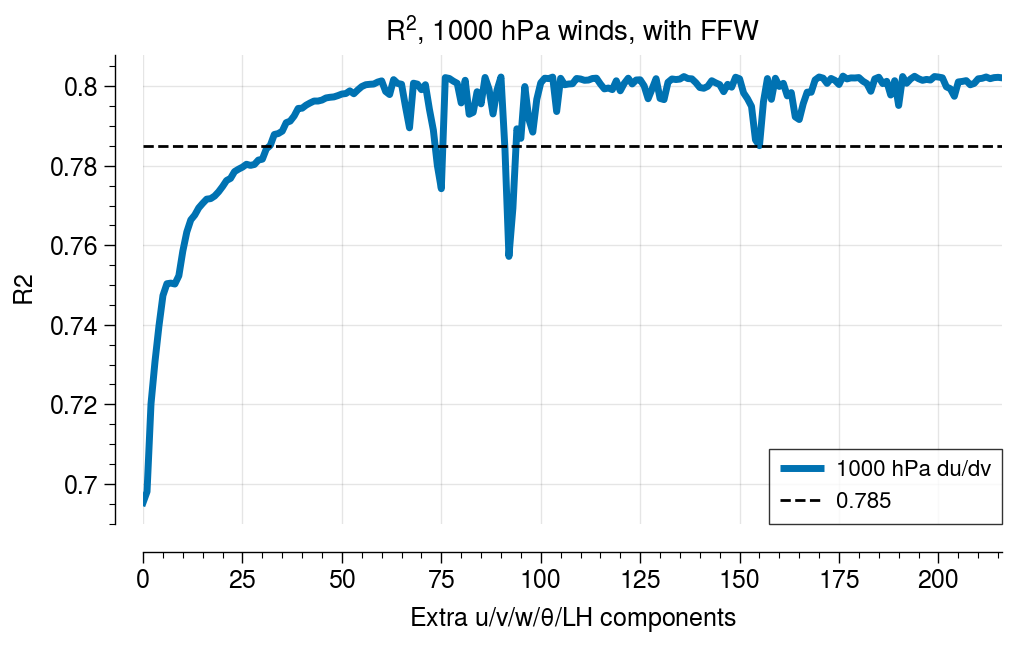

In [19]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
#labels = ['93% Q[29]','95% Q[36]','97% Q[46]','98% Q[53]','99% Q[63]']
axs[0].plot(r2_list,label='1000 hPa du/dv',lw=2.5)
axs[0].axhline(y=0.785,lw=1,ls='--',c='k',label='0.785')
adjust_spines(axs[0], ['left', 'bottom'])
axs.legend(loc='lr',prop={'size':8},ncols=1)
axs[0].format(xlabel=r'Extra u/v/w/$\theta$/LH components',ylabel='R${2}$',title='R$^{2}$, 1000 hPa winds, with FFW')
#plt.savefig('./figures/0308/r2_noFFS_more.png',dpi=300)
plt.savefig('./figures/0406/r2_withFFW.png',dpi=300)
plt.show()

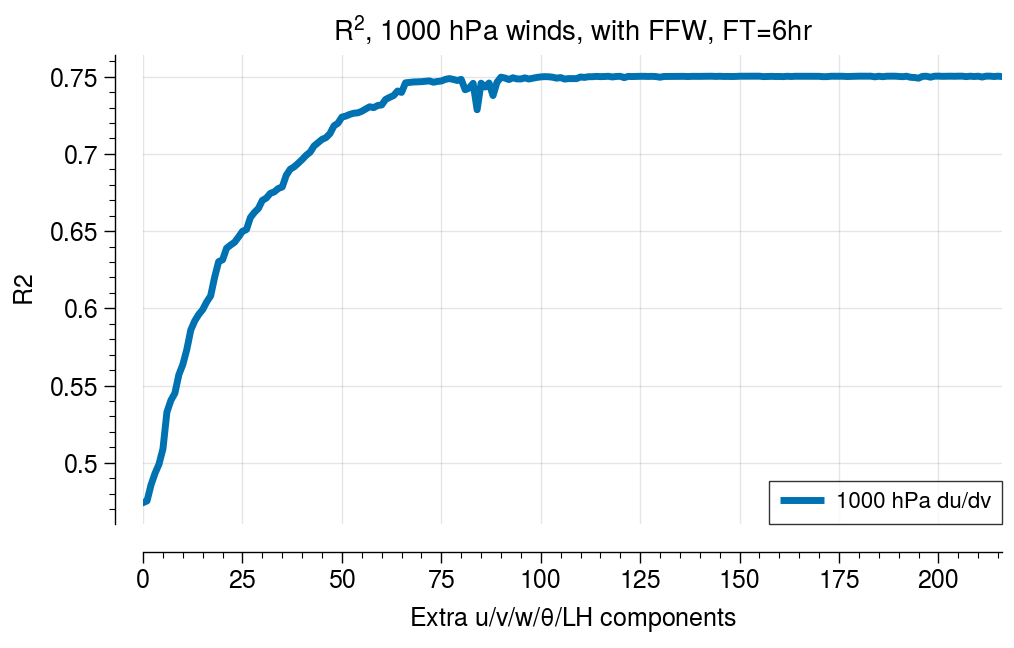

In [13]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
#labels = ['93% Q[29]','95% Q[36]','97% Q[46]','98% Q[53]','99% Q[63]']
axs[0].plot(mlr_r2,label='1000 hPa du/dv',lw=2.5)
#axs[0].axhline(y=0.785,lw=1,ls='--',c='k',label='0.785')
adjust_spines(axs[0], ['left', 'bottom'])
axs.legend(loc='lr',prop={'size':8},ncols=1)
axs[0].format(xlabel=r'Extra u/v/w/$\theta$/LH components',ylabel='R${2}$',title='R$^{2}$, 1000 hPa winds, with FFW, FT=6hr')
#plt.savefig('./figures/0308/r2_noFFS_more.png',dpi=300)
plt.savefig('./figures/0406/r2_withFFW_6hr.png',dpi=300)
plt.show()

In [60]:
weight = models[14].coef_
WEIGHTZ = np.zeros_like(weight)
for weightz in range(reducedX[14].shape[1]):
    tempweight = weight[:,weightz]
    tstemp = reducedX[14][:,weightz]
    temp = np.nanmean(np.asarray([temp*tstemp for temp in tempweight]),axis=1)
    WEIGHTZ[:,weightz] = temp

In [51]:
mlrIN,mlrOUT = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(mlr_inputdict['dtthuvw'],mlr_output)

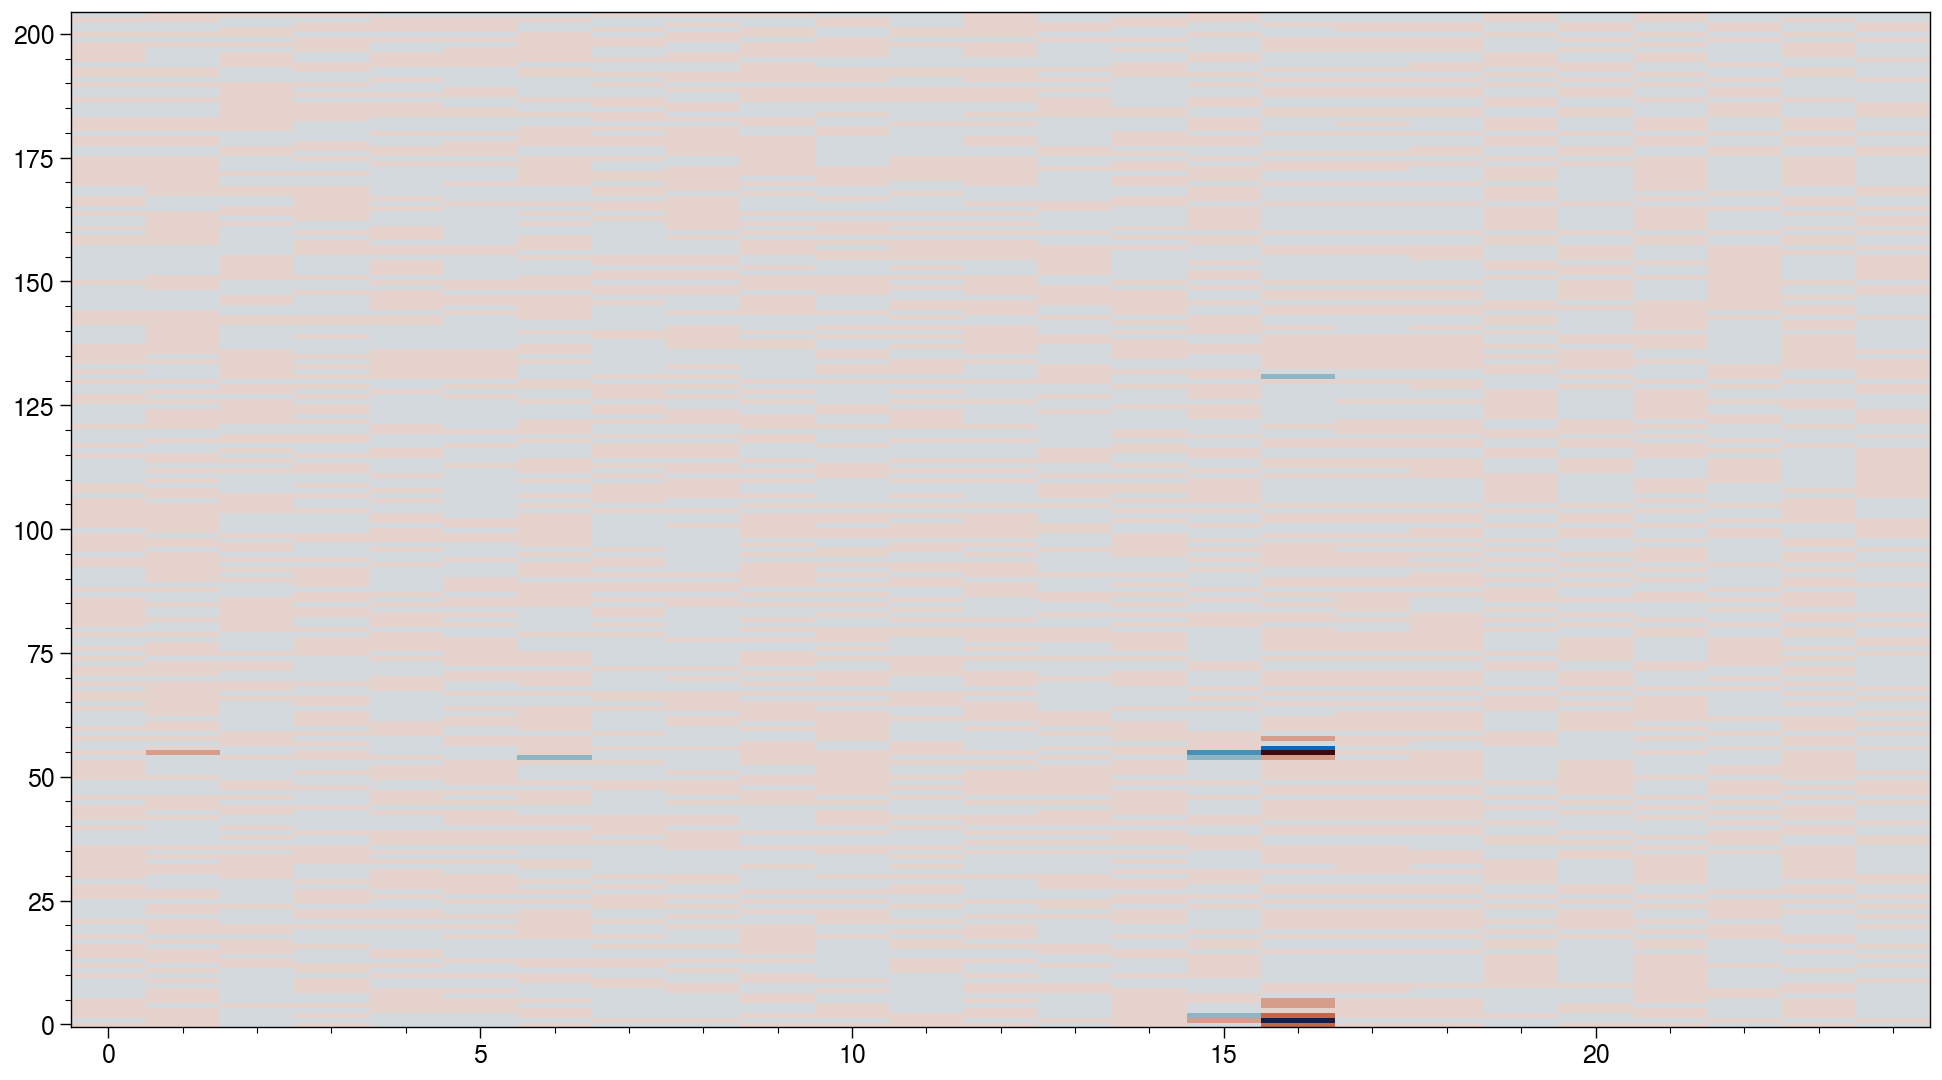

In [61]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=9.295,refaspect=1.831)
axs[0].pcolormesh(WEIGHTZ,cmap='balance')
plt.show()